In [64]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np

import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9) 

start = datetime.datetime(2016,1,1)
end = datetime.date.today()

def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices
 
    :return: pandas DataFrame with adjusted stock data
 
    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas Yahoo! Finance API.
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                       "Close": dat["Adj Close"]})

Populating the interactive namespace from numpy and matplotlib


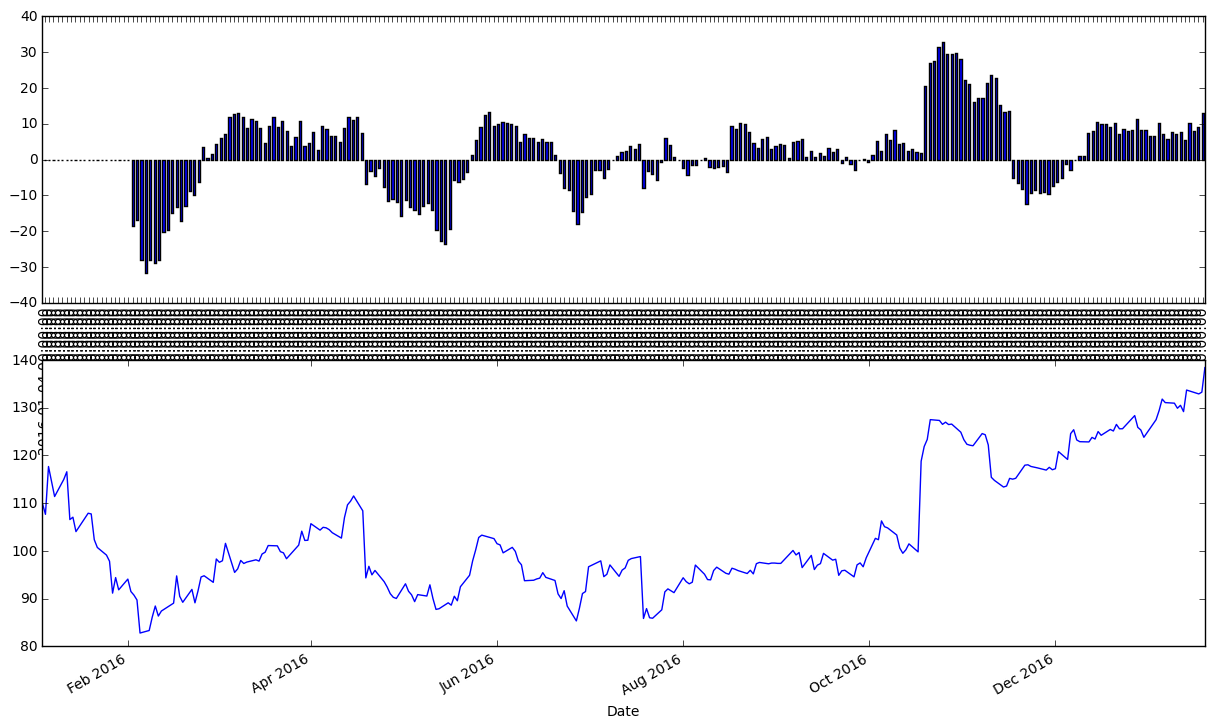

In [112]:
netflix = web.DataReader("NFLX", "yahoo", start, end)


def ma_crossover_order(s, fast, slow, max_loss): 
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
    
#     s = ohlc_adj(s)

#     s[fast_str] = np.round(s["Close"].rolling(window = fast, center = False).mean(), 2)
#     s[slow_str] = np.round(s["Close"].rolling(window = slow, center = False).mean(), 2)
#     s[ma_diff_str] = s[fast_str] - s[slow_str]
#     s["Regime"] = np.where(s[ma_diff_str] > 0, 1, 0)
    
    s["Momentum"] = s['Close'] - s['Close'].shift(20)
    
#     return s["Momentum"]
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    s['Momentum'].plot(ax=axes[0], kind='bar')
    s['Close'].plot(ax=axes[1])


ma_crossover_order(netflix, 20, 50, 10)

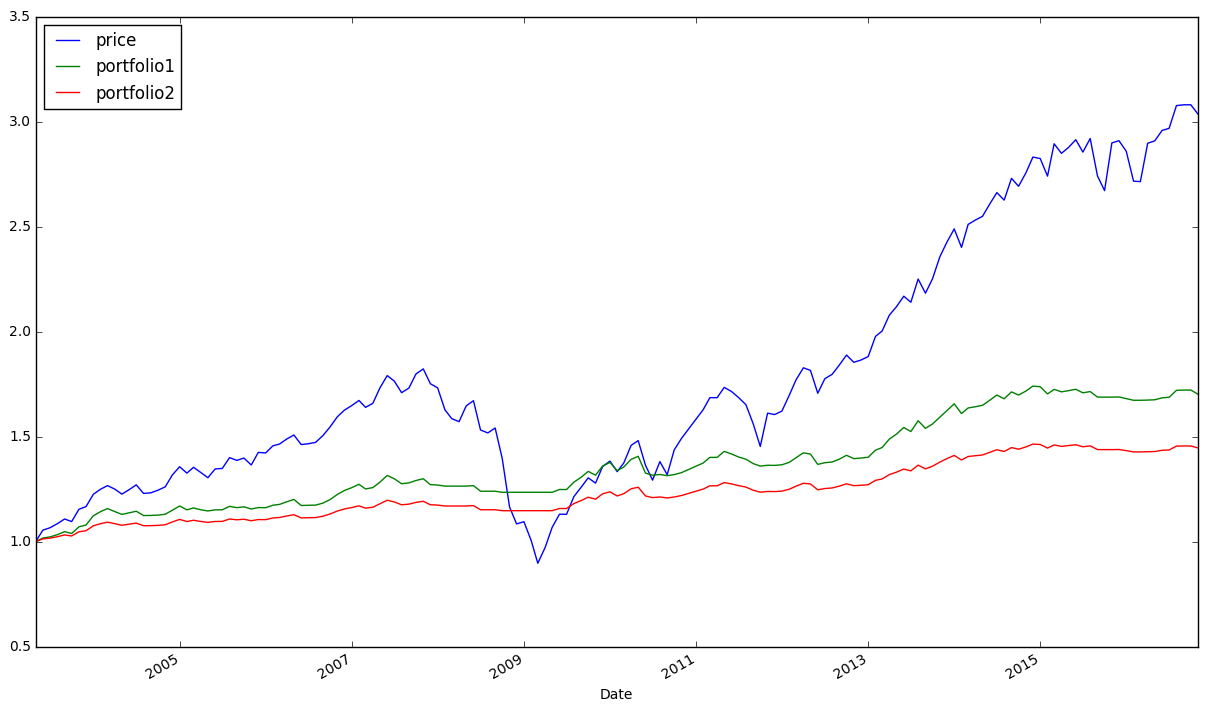

In [40]:
def price(stock, start):
    price = web.DataReader(name=stock, data_source='yahoo', start=start)['Adj Close']
    return price.div(price.iat[0]).resample('M').last().to_frame('price')

def fractal(a,p):
    a['direction'] = np.where(a['price'].diff(p)>0,1,0)
    a['abs'] = a['price'].diff(p).abs()
    a['volatility'] = a.price.diff().abs().rolling(p).sum()
    a['fractal'] = a['abs'].values/a['volatility'].values*a['direction'].values
    return a['fractal']

def meanfractal(a):
    a['meanfractal']= (fractal(a,1).values+fractal(a,2).values+fractal(a,3).values+fractal(a,4).values+fractal(a,5).values+fractal(a,6).values+fractal(a,7).values+fractal(a,8).values+fractal(a,9).values+fractal(a,10).values+fractal(a,11).values+fractal(a,12).values)/12
    a['portfolio1'] = (a.price/a.price.shift(1).values*a.meanfractal.shift(1).values+(1-a.meanfractal.shift(1).values)*1.03**(1/12)).cumprod()
    a['portfolio2'] = ((a.price/a.price.shift(1).values*a.meanfractal.shift(1).values+1.03**(1/12))/(1+a.meanfractal.shift(1))).cumprod()
    a=a.dropna()
    a=a.div(a.ix[0])
    return a[['price','portfolio1','portfolio2']].plot()

meanfractal(a)

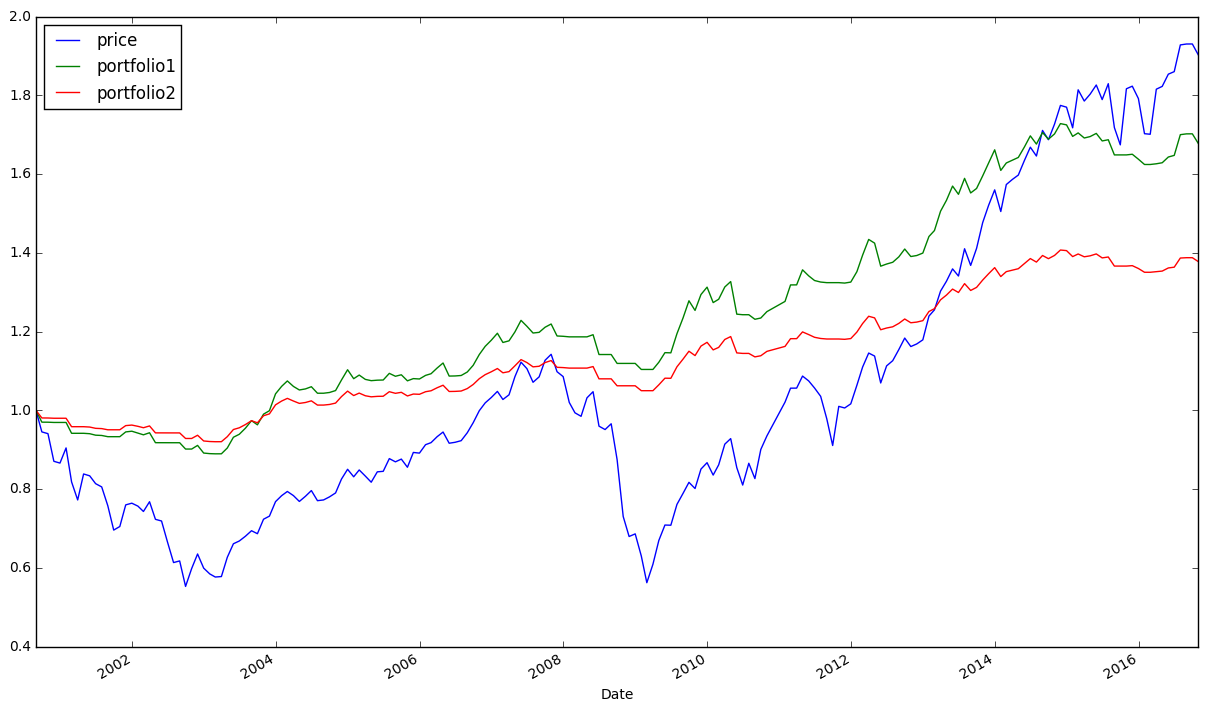

In [59]:
# http://stackoverflow.com/questions/40014258/momentum-portfoliotrend-following-quant-simulation-on-pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web

def price(stock, start, end):
    price = web.DataReader(name=stock, data_source='yahoo', start=start, end=end)['Adj Close']
    return price.div(price.iat[0]).resample('M').last().to_frame('price')

a = price('SPY','2000-01-01', '2016-10-16')

def fractal(a, p):
    df = pd.DataFrame()
    for count in range(1,p+1):
        a['direction'] = np.where(a['price'].diff(count)>0,1,0)
        a['abs'] = a['price'].diff(count).abs()
        a['volatility'] = a.price.diff().abs().rolling(count).sum()
        a['fractal'] = a['abs']/a['volatility']*a['direction']
        df = pd.concat([df, a['fractal']], axis=1)
    return df

def meanfractal(a, l=6):
    a['meanfractal']= pd.DataFrame(fractal(a, l)).sum(1,skipna=False)/l
    mean_shift = a['meanfractal'].shift(1)
    price_shift = a['price'].shift(1)
    factor = 1.03**(1/l)
    a['portfolio1'] = (a['price']/price_shift*mean_shift+(1-mean_shift)*factor).cumprod()
    a['portfolio2'] = ((a['price']/price_shift*mean_shift+factor)/(1+mean_shift)).cumprod()
    a.dropna(inplace=True)
    a = a.div(a.ix[0])
    return a[['price','portfolio1','portfolio2']].plot() 

meanfractal(a)